In [1]:
import nbimporter
import Generalized_Galton_Board # This imports from Generalized_Galton_Board.ipynb
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import HGate, RYGate, RXGate, XGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager, Layout
from qiskit.transpiler.passes import *
from qiskit_ibm_transpiler.ai.routing import AIRouting

# General codes from Generalized_Galton_Board.ipynb

def _pair_sequence_shift_third(r: int, centre: int, right_edge: int) -> list[tuple[int, int]]:
    """Generate pairs of qubits for controlled swaps and CNOT operation in the Galton box.

    Args:
        r (int): Current row index
        centre (int): Centre qubit index
        right_edge (int): set to 2n + 1 for Galton box with n rows
    
    Returns:
        list[tuple[int, int]]: List of pairs of qubit indices for controlled swaps
    """
    pairs = []
    first, second = (centre - r, centre - r + 1), (centre - r + 1, centre - r + 2)
    pairs.extend([first, second])

    if r == 1:  
        return pairs

    gap = 2 * r - 3
    third = (second[1] + gap, second[1] + gap + 1)
    if third[1] <= right_edge:
        pairs.append(third)

    cur = third[0] - 1
    while len(pairs) < 2 * r and cur >= first[0]:
        pair = (cur, cur + 1)
        if pair not in pairs:
            pairs.append(pair)
        cur -= 1
    return pairs

def galton_box_shifted(n: int, coin_gate, *, draw=False) -> QuantumCircuit:
    """
    Quantum Galton Box with customizable coin operations
    
    Args:
        n (int): Number of rows/levels in the Galton box
        coin_gate: Quantum gate or function that returns a gate.
                   If function, should take row index (r) as input.
        draw (bool): Whether to draw the circuit
    
    Returns:
        QuantumCircuit: Configured Galton box circuit
    """
    total_q = 2 * n + 2
    data_q = n + 1
    centre = n + 1
    right = 2*n + 1
    anc = 0

    q = QuantumRegister(total_q, 'q')
    c = ClassicalRegister(data_q, 'c')
    qc = QuantumCircuit(q, c)
    
    # Initialize ball at center
    qc.x(centre)

    # Process rows 1 to n-1 with custom coin gate
    for r in range(1, n):
        qc.reset(anc)
        
        # Apply custom coin operation
        if callable(coin_gate):
            # If coin_gate is a function, call it with current row index
            gate = coin_gate(r)
        else:
            # Use the gate directly
            gate = coin_gate
            
        qc.append(gate, [anc])

        # Get all swap pairs for current row
        pairs = _pair_sequence_shift_third(r, centre, right)

        # Apply controlled-swap operations
        for i, (a, b) in enumerate(pairs):
            qc.cswap(anc, a, b)
            
            # Apply CX to next control
            if i < len(pairs) - 1:
                next_a, _ = pairs[i + 1]
                cx_control = b if next_a > a else a
                qc.cx(cx_control, anc)

    # Process final row (n) with custom ancilla gate
    qc.reset(anc)
    
    # Apply same coin selection logic for final row
    if callable(coin_gate):
        gate = coin_gate(n)  # Use row index n for final row
    else:
        gate = coin_gate
    qc.append(gate, [anc])

    # Final swap sequence
    i = 0
    while i <= 2*n -2:
        qc.cswap(anc, i + 1, i + 2)
        qc.cx(i + 2, anc)
        qc.cswap(anc, i + 2, i + 3)
        if i + 4 < 2*n +1:
            qc.cx(i + 3, anc)
        i += 2
        
    if draw:
        qc.draw('mpl', style='clifford', fold=True)
        plt.show()

    # Measure odd data qubits, as only they are relevant for the final distribution
    for i in range(0, data_q):
        qc.measure(q[2*i+1], c[i])

    return qc


## Setting Up Noisy Backend Simulators

This section implements realistic noise models by creating simulators that replicate the error characteristics and physical constraints of actual IBM quantum processors. We analyze how hardware limitations affect the Quantum Galton Board (QGB) algorithm performance compared to the idealized noiseless simulations from `Generalized_Galton_Board.ipynb`.

Real quantum devices impose fundamental constraints that significantly affect algorithm execution:

- **Number of qubits**: Total physical qubits available on the quantum processor
- **Coupling map**: Graph showing which qubits can directly interact (perform two-qubit gates)
- **Readout error**: Probability of measurement errors when reading qubit states
- **Basis gates**: Native gate set that the hardware can execute directly 
- **Gate fidelities**: Imperfect gate operations introducing computational errors

To execute circuits on realistic hardware, we employ Qiskit's **Pass Manager** for automated circuit optimization and hardware mapping (logical to physical qubits):

- **optimization_level=3**: Highest optimization level that performs aggressive circuit simplification, gate reduction, and routing optimization
- **seed_transpiler**: Ensures reproducible results by fixing the randomness in optimization algorithms
- The pass manager handles gate decomposition, qubit mapping, and circuit optimization automatically

This realistic simulation framework enables quantitative analysis of how quantum noise degrades the QGB's statistical properties.

In [2]:
service = QiskitRuntimeService(name= 'general-use') # please save your details first, and change the instance name accordingly
# service.saved_accounts()
seed= 42

real_backends = service.backends()
print(f"The quantum computers available for you are {real_backends}")

real_backends = [
    service.backend("ibm_brisbane"),
    service.backend("ibm_torino"),
]

noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")

# Taking the ibm_torino as an example
properties = noisy_fake_backends[1].properties()
print(f"Properties of the backend {noisy_fake_backends[1].name}:")
print(f"Number of qubits: {noisy_fake_backends[1].num_qubits}")
# print(f"Coupling map: {noisy_fake_backends[1].coupling_map}")
print(f"Readout error: {properties.readout_error(1)}")
print(noisy_fake_backends[1].configuration().basis_gates)

The quantum computers available for you are [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]
The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['reset', 'measure', 'x', 'id', 'sx', 'ecr']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['reset', 'measure', 'cz', 'x', 'id', 'sx']>)]
Properties of the backend aer_simulator_from(ibm_torino):
Number of qubits: 133
Readout error: 0.053466796875
['cz', 'id', 'rz', 'sx', 'x', 'break_loop', 'continue_loop', 'delay', 'for_loop', 'if_else', 'initialize', 'kraus', 'qerror_loc', 'quantum_channel', 'reset', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix'

### Circuit Error Analysis and Characterization Functions

In [3]:
def circuit_error_analysis(backend, circuit: QuantumCircuit, n: int) -> dict:
    """
    Comprehensive error analysis for a transpiled quantum circuit.
    
    Args:
        backend: Quantum backend with properties
        circuit: Transpiled quantum circuit
        n: Number of levels in Galton board (for readout error calculation)
    
    Returns:
        dict: Complete error analysis including totals, breakdowns, and pair details
    """
    properties = backend.properties()
    
    acc_single_qubit_error = 0
    single_qubit_gate_count = 0
    two_qubit_gate_count = 0
    pair_dict = {}  
    
    basis_gates = backend.configuration().basis_gates
    two_qubit_gate = "ecr" if "ecr" in basis_gates else "cz"
    
    # Process all instructions in one pass
    for instruction in circuit.data:
        num_qubits = instruction.operation.num_qubits
        operation_name = instruction.operation.name
        
        if num_qubits == 1 and operation_name not in ['measure', 'reset']:
            # Single-qubit gate processing
            try:
                qubits = [circuit.qubits.index(q) for q in instruction.qubits]
                acc_single_qubit_error += properties.gate_error(gate=operation_name, qubits=qubits)
                single_qubit_gate_count += 1
            except (ValueError, KeyError):
                # Skip if gate error data not available for this qubit
                single_qubit_gate_count += 1
                
        elif num_qubits == 2:
            # Two-qubit gate processing
            two_qubit_gate_count += 1
            pair = tuple(sorted([instruction.qubits[0]._index, instruction.qubits[1]._index]))
            
            try:
                error = properties.gate_error(gate=two_qubit_gate, qubits=list(pair))
                
                if pair in pair_dict:
                    pair_dict[pair]['accumulated_error'] += error
                    pair_dict[pair]['count'] += 1
                else:
                    pair_dict[pair] = {
                        'single_error': error,
                        'accumulated_error': error,
                        'count': 1
                    }
            except (ValueError, KeyError):
                # Skip if gate error data not available for this qubit pair
                # This can happen when qubits are not connected or error data is missing
                # print(f"Warning: Could not find error data for {two_qubit_gate} gate on qubits {pair}")
                if pair not in pair_dict:
                    pair_dict[pair] = {
                        'single_error': 0.0,
                        'accumulated_error': 0.0,
                        'count': 1
                    }
                else:
                    pair_dict[pair]['count'] += 1
    
    # Calculate readout errors with error handling
    try:
        qubit_layout = list(circuit.layout.initial_layout.get_physical_bits().keys())[:2*n + 1]
        acc_readout_error = 0
        for q in qubit_layout:
            try:
                acc_readout_error += properties.readout_error(q)
            except (ValueError, KeyError):
                # print(f"Warning: Could not find readout error for qubit {q}")
                pass
    except (AttributeError, KeyError):
        # print("Warning: Could not access qubit layout, setting readout error to 0")
        acc_readout_error = 0
    
    # Calculate totals
    acc_two_qubit_error = sum(pair_data['accumulated_error'] for pair_data in pair_dict.values())
    acc_total_error = acc_two_qubit_error + acc_single_qubit_error + acc_readout_error
    
    # Prepare pair analysis data
    pair_list = list(pair_dict.keys())
    error_pair_list = [pair_dict[pair]['single_error'] for pair in pair_list]
    error_acc_pair_list = [pair_dict[pair]['accumulated_error'] for pair in pair_list]
    
    return {
        # Detailed error breakdown
        'errors': {
            'total': acc_total_error,
            'two_qubit': acc_two_qubit_error,
            'single_qubit': acc_single_qubit_error,
            'readout': acc_readout_error
        },
        
        # Gate counts
        'gate_counts': {
            'single_qubit': single_qubit_gate_count,
            'two_qubit': two_qubit_gate_count
        },
        
        # Two-qubit pair analysis
        'pair_analysis': {
            'pairs': pair_list,
            'single_errors': error_pair_list,
            'accumulated_errors': error_acc_pair_list,
            'pair_details': pair_dict
        }
    }

### Functions for post processing and comparing distributions

In [4]:
def counts_to_probabilities(counts):
    total_shots = sum(counts.values())
    return {state: count / total_shots for state, count in counts.items()}


def filter_counts_by_hamming_weight(counts: dict) -> dict:
    """
    Filters a dictionary of measurement counts, keeping only the outcomes
    that have a Hamming weight of 1.

    Args:
        counts (dict): The dictionary of measurement outcomes and their counts.
                       The keys are binary strings (e.g., '0100').

    Returns:
        dict: A new dictionary with only the filtered counts.
    """
    filtered_counts = {}
    for outcome, count in counts.items():
        if outcome.count('1') == 1:
            filtered_counts[outcome] = count
    return filtered_counts

def total_variation_distance(p_dist, q_dist):
    """Computes the Total Variation Distance between two distributions."""
    states = set(p_dist.keys()) | set(q_dist.keys())
    tvd = 0.5 * sum(abs(p_dist.get(state, 0) - q_dist.get(state, 0)) for state in states)
    return tvd

def kullback_leibler_divergence(p_dist, q_dist):
    """Computes the KL divergence of P from Q. Assumes P is the noisy distribution."""
    states = set(p_dist.keys()) | set(q_dist.keys())
    kl_div = 0
    for state in states:
        p_prob = p_dist.get(state, 0)
        q_prob = q_dist.get(state, 0)
        # Avoid log(0)
        if p_prob > 0 and q_prob > 0:
            kl_div += p_prob * np.log(p_prob / q_prob)
    return kl_div


def compare_distributions(noisy_counts, noiseless_counts, n, 
                         filter_hamming=False, 
                         title_prefix="", 
                         figsize=(8, 5),
                         show_metrics=True,
                         return_metrics=False):
    """
    Generalized function to compare noisy and noiseless quantum distributions.
    
    Args:
        noisy_counts (dict): Counts from noisy simulation
        noiseless_counts (dict): Counts from noiseless simulation  
        n (int): Number of levels in Galton board
        filter_hamming (bool): Whether to filter by Hamming weight = 1
        title_prefix (str): Prefix for the plot title
        figsize (tuple): Figure size for the plot
        show_metrics (bool): Whether to print distance metrics
        return_metrics (bool): Whether to return metrics as dict
        
    Returns:
        dict (optional): Dictionary containing TVD and KL divergence if return_metrics=True
    """
    
    # Apply Hamming weight filter if requested
    if filter_hamming:
        noisy_counts = filter_counts_by_hamming_weight(noisy_counts)
        filter_text = " (Filtered)"
    else:
        filter_text = ""
    
    # Convert to probabilities
    p_noisy = counts_to_probabilities(noisy_counts)
    p_noiseless = counts_to_probabilities(noiseless_counts)
    

    fig, ax = plt.subplots(figsize=figsize)
    
    # Get all unique states and their probabilities
    all_states = sorted(list(set(p_noisy.keys()) | set(p_noiseless.keys())))
    x_ticks = np.arange(len(all_states))
    width = 0.35 # Width of the bars
    
    noisy_probs = [p_noisy.get(state, 0) for state in all_states]
    noiseless_probs = [p_noiseless.get(state, 0) for state in all_states]
    
    ax.bar(x_ticks - width/2, noiseless_probs, width, label='Noiseless', color='royalblue')
    ax.bar(x_ticks + width/2, noisy_probs, width, label=f'Noisy{filter_text}', color='salmon')
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(all_states, rotation=90)
    ax.set_xlabel("Measured States")
    ax.set_ylabel("Probability")
    if title_prefix:
        title = f"{title_prefix} (n={n})"
    else:
        title = f"Comparison of Noisy and Noiseless Distributions (n={n})"
    ax.set_title(title)
    
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    tvd = np.abs(total_variation_distance(p_noisy, p_noiseless))
    kl_div = np.abs(kullback_leibler_divergence(p_noisy, p_noiseless))

    if show_metrics:
        print(f"Total Variation Distance (TVD): {tvd:.4f}")
        print(f"Kullback-Leibler Divergence (KL): {kl_div:.4f}")
    
    if return_metrics:
        return {
            'tvd': tvd,
            'kl_divergence': kl_div,
            'noisy_probabilities': p_noisy,
            'noiseless_probabilities': p_noiseless
        }


## 3-Level QGB: Noisy Hardware Simulation

As an example we demonstrate a $3$ level QGB on a noisy simulator.

In [5]:
n=3 # number of levels in the Galton board
qc = galton_box_shifted(n, HGate(), draw=False)
backend= AerSimulator.from_backend(noisy_fake_backends[1])  # Using the noisy simulator for ibm_torino
qc_transpiled = transpile(qc, backend, optimization_level=3)
qubit_layout = list(qc_transpiled.layout.initial_layout.get_physical_bits().keys())[:2*n +1] 
print(f"Qubit layout: {qubit_layout}")

print('Gates used on the noisy simulator:', qc_transpiled.count_ops()) 

Qubit layout: [61, 60, 62, 54, 59, 63, 58]
Gates used on the noisy simulator: OrderedDict([('sx', 326), ('rz', 230), ('cz', 170), ('x', 7), ('measure', 4), ('reset', 3)])


#### The noisy simulation results show additional measurement outcomes not present in the ideal case. 

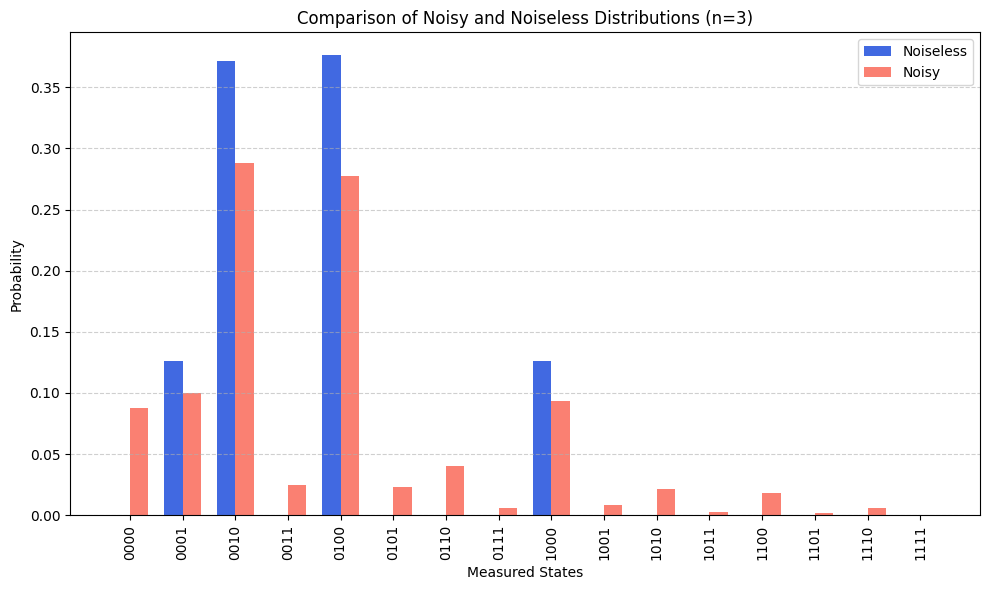

In [6]:
# Run noisy simulation
job = backend.run(qc_transpiled, shots=100000)  # Using same shot count for fair comparison
noisy_counts = job.result().get_counts()

# Run noiseless simulation
backend_wo_noise = AerSimulator()
compiled = transpile(qc, backend_wo_noise, optimization_level=3)
job = backend_wo_noise.run(compiled, shots=100000)  # Using same shot count for fair comparison
noiseless_counts = job.result().get_counts()

# Compare distributions
compare_distributions(noisy_counts, noiseless_counts, n=n, 
                      filter_hamming=False, 
                      title_prefix="Comparison of Noisy and Noiseless Distributions",
                      figsize=(10, 6),
                      show_metrics=False,
                      return_metrics=False)


## Optimizing the transpiled circuit to achieve better closeness

### Post-Transpilation Error Analysis



In [7]:
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:

    backend= AerSimulator.from_backend(noisy_fake_backend)  # Using the noisy simulator for ibm_torino
    circuit_transpiled = transpile(qc, backend, optimization_level=3)
    qubit_layout = list(circuit_transpiled.layout.initial_layout.get_physical_bits().keys())[:2*n +1] 

    error_analysis = circuit_error_analysis(noisy_fake_backend, circuit_transpiled, n)
    errors_and_counts = [
        error_analysis['errors']['total'],
        error_analysis['errors']['two_qubit'], 
        error_analysis['errors']['single_qubit'],
        error_analysis['errors']['readout'],
        error_analysis['gate_counts']['single_qubit'],
        error_analysis['gate_counts']['two_qubit']
    ]
    errors_and_counts_list.append(errors_and_counts)


for backend, (
    acc_total_error,
    acc_two_qubit_error,
    acc_single_qubit_error,
    acc_readout_error,
    single_qubit_gate_count,
    two_qubit_gate_count,
) in zip(noisy_fake_backends, errors_and_counts_list):
    print(f"Backend {backend.name}")
    print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
    print(
        f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
    )
    print(f"Accumulated readout error: {acc_readout_error:.3f}")
    print(f"Accumulated total error: {acc_total_error:.3f}\n")

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Backend aer_simulator_from(ibm_brisbane)
Accumulated two-qubit error of 169 gates: 0.561
Accumulated one-qubit error of 870 gates: 0.072
Accumulated readout error: 0.094
Accumulated total error: 0.727

Backend aer_simulator_from(ibm_torino)
Accumulated two-qubit error of 171 gates: 0.359
Accumulated one-qubit error of 570 gates: 0.093
Accumulated readout error: 0.096
Accumulated total error: 0.547



#### Let's try to map the logical qubits to physical qubits with a goal of reducing the two qubit gate error.

The function `finding_best_seed` searches through 500 different transpiler seeds using the SABRE layout method to find the optimal qubit mapping that minimizes two-qubit gate errors for a given quantum circuit and backend.

**Note:** SABRE (SWAP-based Bidirectional heuristic for Routing) is an advanced qubit routing algorithm that efficiently maps logical qubits to physical qubits by minimizing the number of SWAP gates needed to satisfy hardware connectivity constraints.

In [8]:
def finding_best_seed(
    circuit: QuantumCircuit, backend, n: int, layout: str, seed_transpiler: int
) -> tuple[QuantumCircuit, int, float, int]:
    """Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend."""

    # We initialize the minimum error accumulated
    min_err_acc_seed_loop = 100
    circuit_opt_best_seed = None
    best_seed_transpiler = 0
    
    for seed_transpiler in range(0, seed_transpiler):
        pm = generate_preset_pass_manager(
            backend=backend,
            optimization_level=3,
            seed_transpiler=seed_transpiler,
            layout_method= layout,  # dense layout gave a higher error than sabre
        )

        circuit_opt_seed = pm.run([circuit])[0]
        
        error_analysis = circuit_error_analysis(backend, circuit_opt_seed, n)
        acc_total_error_seed_loop = error_analysis['errors']['total']

        if acc_total_error_seed_loop < min_err_acc_seed_loop:
            min_err_acc_seed_loop = acc_total_error_seed_loop
            circuit_opt_best_seed = circuit_opt_seed
            best_seed_transpiler = seed_transpiler

    return (
        circuit_opt_best_seed,
        best_seed_transpiler,
        min_err_acc_seed_loop
    )

optimization_results = []  # collect per-backend optimization metrics

for noisy_fake_backend in noisy_fake_backends:
    print(f"Optimizing for Backend: {noisy_fake_backend.name}")
    (
        circuit_opt_seed_loop,
        best_seed_transpiler,
        min_err_acc_seed_loop,
    ) = finding_best_seed(qc, noisy_fake_backend, n, "sabre", 500)  

    best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:2*n+1]
    error_analysis = circuit_error_analysis(noisy_fake_backend, circuit_opt_seed_loop, n)

    total_error = error_analysis['errors']['total']

    print(f"  Seed: {best_seed_transpiler}")
    print(f"  Layout: {best_layout}")
    print(f"  TOTAL error: {total_error:.3f}")

    optimization_results.append({
        "backend": noisy_fake_backend,
        "seed": best_seed_transpiler,
        "layout": best_layout,
        "circuit": circuit_opt_seed_loop,
        "total_error": total_error
    })


best_total = min(optimization_results, key=lambda r: r["total_error"])
print("=== Best (by total accumulated error) ===")
print(f"Backend: {best_total['backend']}")
print(f"Seed: {best_total['seed']}")
print(f"Total error: {best_total['total_error']:.3f}")
print(f"Layout: {best_total['layout']}")
best_total_circuit = best_total["circuit"]  # <- circuit with least total error

Optimizing for Backend: aer_simulator_from(ibm_brisbane)
  Seed: 371
  Layout: [0, 18, 14, 2, 1, 3, 4]
  TOTAL error: 0.250
Optimizing for Backend: aer_simulator_from(ibm_torino)
  Seed: 148
  Layout: [59, 62, 54, 61, 60, 72, 58]
  TOTAL error: 0.520
=== Best (by total accumulated error) ===
Backend: AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['reset', 'measure', 'x', 'id', 'sx', 'ecr']>)
Seed: 371
Total error: 0.250
Layout: [0, 18, 14, 2, 1, 3, 4]


- **Through optimal logical-to-physical qubit mapping, we achieved a significant reduction in accumulated two-qubit gate error for the n=3 QGB implementation. Even the total error has decreased.**

- **Note: This specific pass manager settings cannot be a general strategy for any number of layers. One has to carefully work with finding the optimal layout for different circuit sizes as different physical qubits have very different characteristics.**



#### Post-processing and Finding distances between the distributions

Since the theoretical Quantum Galton Board produces measurement outcomes with exactly one '1' and the remaining bits as '0' (i.e., bitstrings with Hamming weight 1), we can filter out noise-induced erroneous samples by retaining only these valid outcomes. This can be achieved by setting the `filter_hamming` parameter of the `compare_distributions` to True. 

The final distribution is compared against the noiseless distribution via the Kullback Leibler Divergence and Total variation distance metrics. This comparison is achieived by setting the `show_metrics` parameter to True.

**Note:**

- Kullback-Leibler divergence quantifies how one probability distribution diverges from another, often considered a reference. It is a non-symmetric measure where a value of zero indicates that the distributions are identical.

- Total Variation Distance measures the maximum absolute difference between the probabilities of any event in two distributions. It is a true metric with a value ranging from 0 (identical distributions) to 1 (maximally different distributions).

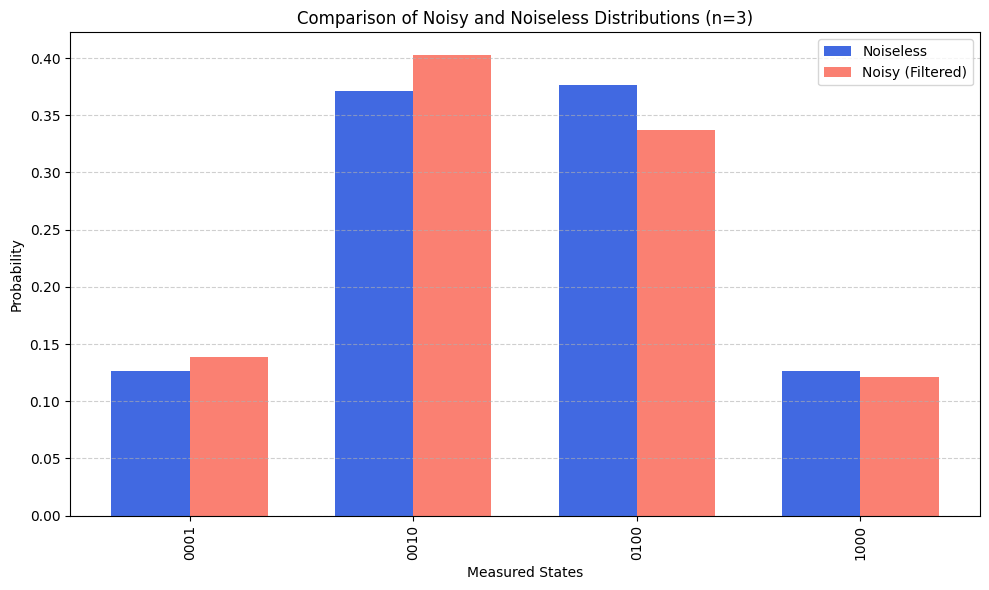

Total Variation Distance (TVD): 0.0438
Kullback-Leibler Divergence (KL): 0.0041


In [9]:
best_backend = best_total['backend']  # Use the backend from the best optimization result
backend= AerSimulator.from_backend(best_backend)
job = backend.run(best_total_circuit, shots=100000) 
noisy_counts = job.result().get_counts()

compare_distributions(noisy_counts, noiseless_counts, n=n, 
                      filter_hamming=True, 
                      title_prefix="Comparison of Noisy and Noiseless Distributions",
                      figsize=(10, 6),
                      show_metrics=True,
                      return_metrics=False)


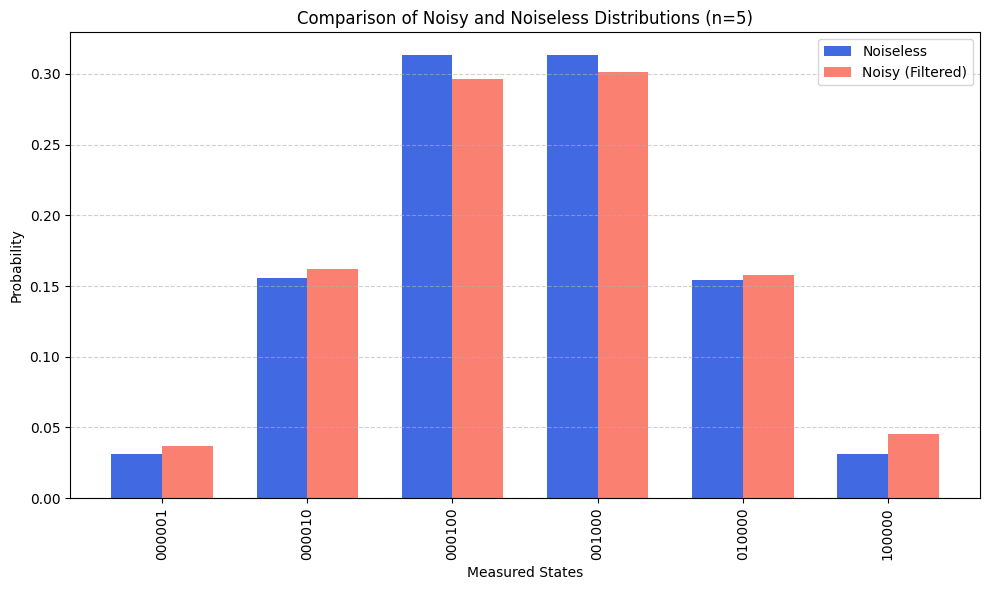

Total Variation Distance (TVD): 0.0289
Kullback-Leibler Divergence (KL): 0.0039


In [10]:
n=5 # number of levels in the Galton board
qc = galton_box_shifted(n, HGate(), draw=False)
backend = AerSimulator.from_backend(noisy_fake_backends[1])  # Using the noisy simulator for ibm_torino
qc_transpiled = transpile(qc, backend, optimization_level=3)


# Run noisy simulation 
job = backend.run(qc_transpiled, shots=100000)  # Using same shot count for fair comparison
noisy_counts = job.result().get_counts()


# Run noiseless simulation
backend_wo_noise = AerSimulator()
compiled = transpile(qc, backend_wo_noise, optimization_level=3)
job = backend_wo_noise.run(compiled, shots=100000) 
noiseless_counts = job.result().get_counts()


# Compare distributions
compare_distributions(noisy_counts, noiseless_counts, n=n, 
                      filter_hamming=True, 
                      title_prefix="Comparison of Noisy and Noiseless Distributions",
                      figsize=(10, 6),
                      show_metrics=True,
                      return_metrics=False)


#### Based on our simulation, after the post processing (keeping only the samples with Hamming weight=$1$) the resulting noisy normal distribution very closely resembles the noiseless normal distribution characteristics. 

____

## Complexity Analysis

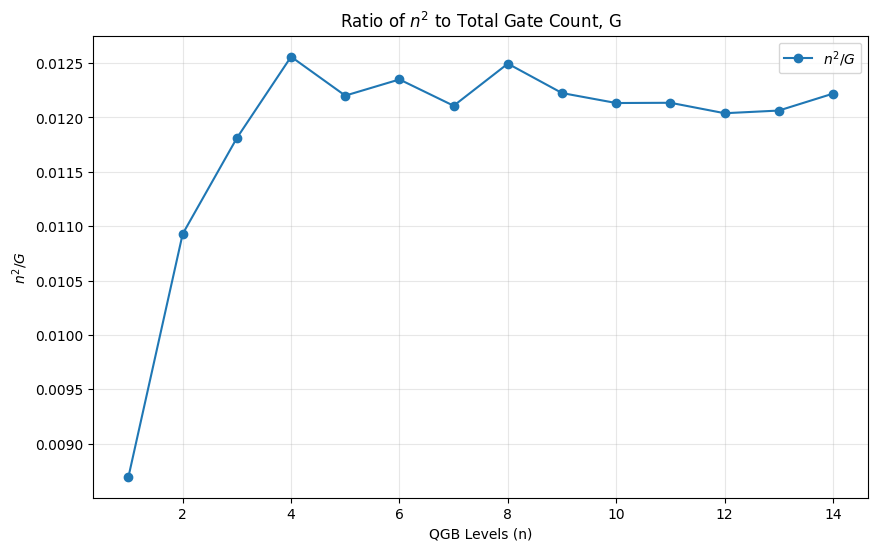

In [11]:
N = []
total_gates = []
for n in range(1, 15):
    qc = galton_box_shifted(n, HGate(), draw=False)
    backend = AerSimulator.from_backend(noisy_fake_backends[1])  # Using the noisy simulator for ibm_torino
    compiled = transpile(qc, backend, optimization_level=3)
    total_gate = sum(compiled.count_ops().values())
    N.append(n)
    total_gates.append(total_gate)

N_array = np.array(N)
total_gates_array = np.array(total_gates)

# Calculate the ratio n^2 / Total Gate Count
ratio_n2_gates = (N_array ** 2) / total_gates_array


fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('QGB Levels (n)')
ax.set_ylabel(r'$n^2 / G$')
ax.plot(N, ratio_n2_gates, 'o-', label=r'$n^2 / G$')
ax.set_title(r'Ratio of $n^2$ to Total Gate Count, G')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

Polynomial fits in log₂(n):
Circuit Depth ≈ 168.09(log₂(n))⁴ + -809.77(log₂(n))³ + 1506.03(log₂(n))² + -728.32(log₂(n)) + 86.61
Circuit Depth R² = 0.9998

Total Gates ≈ 275.90(log₂(n))⁴ + -1315.18(log₂(n))³ + 2428.05(log₂(n))² + -1183.66(log₂(n)) + 122.62
Total Gates R² = 0.9998


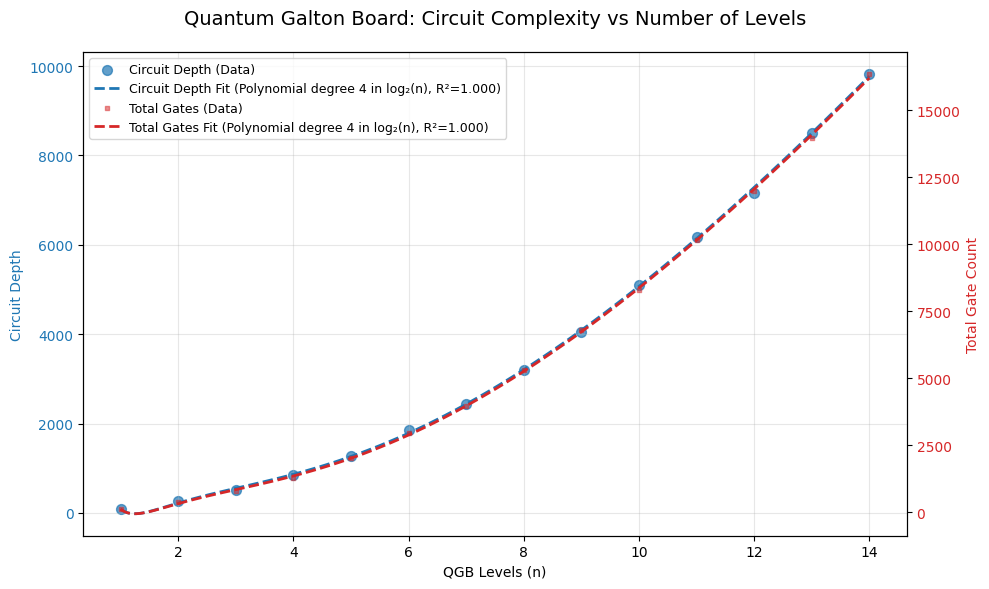

In [12]:
N = []
circuit_depths = []
total_gates = []
for n in range(1, 15):
    qc = Generalized_Galton_Board.galton_box_shifted(n, HGate(), draw=False)
    backend = AerSimulator.from_backend(noisy_fake_backends[1])  # Using the noisy simulator for ibm_torino
    compiled = transpile(qc, backend, optimization_level=3)
    circuit_depth = compiled.depth()
    total_gate = sum(compiled.count_ops().values())
    N.append(n)
    circuit_depths.append(circuit_depth)
    total_gates.append(total_gate)

N_array = np.array(N)
log_N = np.log2(N_array)
circuit_depths_array = np.array(circuit_depths)
total_gates_array = np.array(total_gates)

# Polynomial fitting (degree 4) in log2(n)
poly_degree = 4
depth_coeffs = np.polyfit(log_N, circuit_depths_array, poly_degree)
gates_coeffs = np.polyfit(log_N, total_gates_array, poly_degree)


def calculate_r_squared(y_actual, y_predicted):
    ss_res = np.sum((y_actual - y_predicted) ** 2)
    ss_tot = np.sum((y_actual - np.mean(y_actual)) ** 2)
    return 1 - (ss_res / ss_tot)

# Calculate fitted values for R² computation
depth_fitted = np.polyval(depth_coeffs, log_N)
gates_fitted = np.polyval(gates_coeffs, log_N)

# Calculate R² values
depth_r2 = calculate_r_squared(circuit_depths_array, depth_fitted)
gates_r2 = calculate_r_squared(total_gates_array, gates_fitted)

# Generate smooth curves for plotting
log_N_smooth = np.linspace(log_N.min(), log_N.max(), 100)
N_smooth = 2**log_N_smooth
depth_fit = np.polyval(depth_coeffs, log_N_smooth)
gates_fit = np.polyval(gates_coeffs, log_N_smooth)


fig, ax1 = plt.subplots(figsize=(10, 6))
color1 = 'tab:blue'
ax1.set_xlabel('QGB Levels (n)')
ax1.set_ylabel('Circuit Depth', color=color1)
ax1.scatter(N, circuit_depths, color=color1, s=50, alpha=0.7, label='Circuit Depth (Data)')
ax1.plot(N_smooth, depth_fit, color=color1, linewidth=2, linestyle='--', 
         label=f'Circuit Depth Fit (Polynomial degree {poly_degree} in log₂(n), R²={depth_r2:.3f})')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Total Gate Count', color=color2)
ax2.scatter(N, total_gates, color=color2, s=10, marker='s', alpha=0.5, label='Total Gates (Data)')
ax2.plot(N_smooth, gates_fit, color=color2, linewidth=2, linestyle='--', 
         label=f'Total Gates Fit (Polynomial degree {poly_degree} in log₂(n), R²={gates_r2:.3f})')
ax2.tick_params(axis='y', labelcolor=color2)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)
plt.title('Quantum Galton Board: Circuit Complexity vs Number of Levels', 
          fontsize=14, pad=20)
plt.tight_layout()

print("Polynomial fits in log₂(n):")
print(f"Circuit Depth ≈ {depth_coeffs[0]:.2f}(log₂(n))⁴ + {depth_coeffs[1]:.2f}(log₂(n))³ + {depth_coeffs[2]:.2f}(log₂(n))² + {depth_coeffs[3]:.2f}(log₂(n)) + {depth_coeffs[4]:.2f}")
print(f"Circuit Depth R² = {depth_r2:.4f}")
print(f"\nTotal Gates ≈ {gates_coeffs[0]:.2f}(log₂(n))⁴ + {gates_coeffs[1]:.2f}(log₂(n))³ + {gates_coeffs[2]:.2f}(log₂(n))² + {gates_coeffs[3]:.2f}(log₂(n)) + {gates_coeffs[4]:.2f}")
print(f"Total Gates R² = {gates_r2:.4f}")

plt.show()



##### The empirical analysis demonstrates that as $n$ increases, the ratio $n^2/G$ stabilizes, confirming that the total gate count $G$ for the generalized noisy Galton board scales quadratically with the number of levels, i.e., $G \in O(n^2)$.
##### **Infact, G is also a polynomial function of $log_2(N)$ which suggests much better scaling of the generalized noisy transpiled circuit than $O(n^2)$**

### Thus we argue that in quantum terms the backend aware transpiled circuits are efficient.

___
___

## Noisy simulation for exponential distribution

**Note:** The below code can take couple of minutes (between $5-10$, depending on your device) to execute.

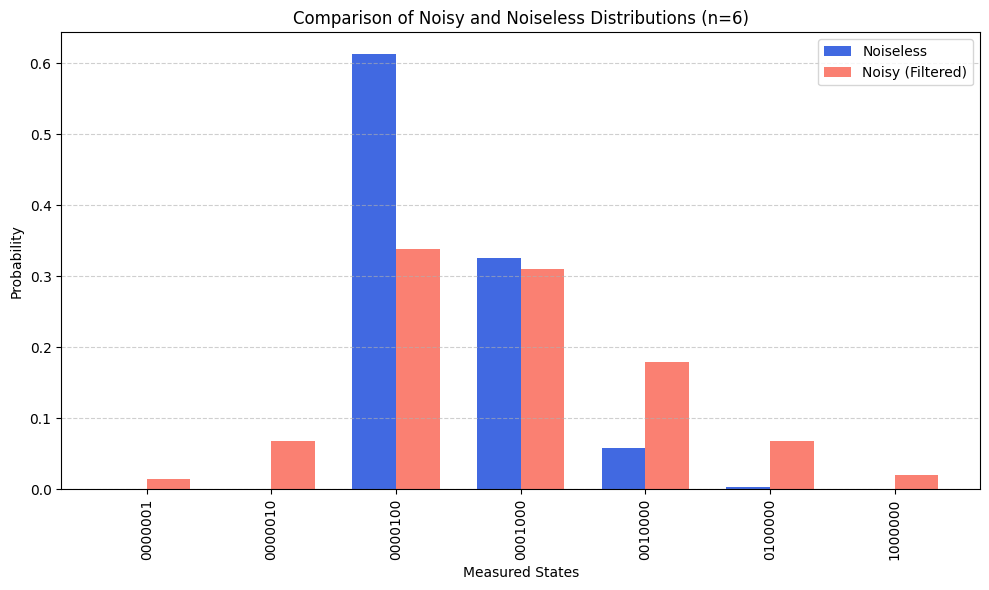

Total Variation Distance (TVD): 0.2901
Kullback-Leibler Divergence (KL): 0.2068


In [13]:
n=6

qc = galton_box_shifted(n, Generalized_Galton_Board.row_dependent_gate_right)
backend = AerSimulator.from_backend(noisy_fake_backends[1])  # Using the noisy simulator for ibm_torino
qc_transpiled = transpile(qc, backend, optimization_level=3)

# Run noisy simulation
job = backend.run(qc_transpiled, shots=10000)  # Using same shot count for fair comparison
noisy_counts = job.result().get_counts()

# Run noiseless simulation
backend_wo_noise = AerSimulator()
compiled = transpile(qc, backend_wo_noise, optimization_level=3)
job = backend_wo_noise.run(compiled, shots=10000)  # Using same shot count for fair comparison
noiseless_counts = job.result().get_counts()

# Filter the counts dictionaries in-place 
# # since we know from theoretical analysis that the first and last two bitstrings don't contribute to the distribution
def filter_counts_inplace(counts: dict, remove_count: int = 2):
    """Filter counts dictionary in-place by removing edge bitstrings."""
    if len(counts) <= 2 * remove_count:
        counts.clear()
        return
    
    sorted_bitstrings = sorted(counts.keys())
    bitstrings_to_remove = sorted_bitstrings[:remove_count] + sorted_bitstrings[-remove_count+1:]
    
    for bitstring in bitstrings_to_remove:
        counts.pop(bitstring, None)


# Compare distributions
compare_distributions(noisy_counts, noiseless_counts, n=n, 
                      filter_hamming=True, 
                      title_prefix="Comparison of Noisy and Noiseless Distributions",
                      figsize=(10, 6),
                      show_metrics=True,
                      return_metrics=False)

In [14]:
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:

    backend= AerSimulator.from_backend(noisy_fake_backend)  # Using the noisy simulator for ibm_torino
    circuit_transpiled = transpile(qc, backend, optimization_level=3)
    qubit_layout = list(circuit_transpiled.layout.initial_layout.get_physical_bits().keys())[:2*n +1] 

    error_analysis = circuit_error_analysis(noisy_fake_backend, circuit_transpiled, n)
    errors_and_counts = [
        error_analysis['errors']['total'],
        error_analysis['errors']['two_qubit'], 
        error_analysis['errors']['single_qubit'],
        error_analysis['errors']['readout'],
        error_analysis['gate_counts']['single_qubit'],
        error_analysis['gate_counts']['two_qubit']
    ]
    errors_and_counts_list.append(errors_and_counts)


for backend, (
    acc_total_error,
    acc_two_qubit_error,
    acc_single_qubit_error,
    acc_readout_error,
    single_qubit_gate_count,
    two_qubit_gate_count,
) in zip(noisy_fake_backends, errors_and_counts_list):
    print(f"Backend: {backend.name}")
    print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
    print(
        f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
    )
    print(f"Accumulated readout error: {acc_readout_error:.3f}")
    print(f"Accumulated total error: {acc_total_error:.3f}\n")



optimization_results = []  # collect per-backend optimization metrics

for noisy_fake_backend in noisy_fake_backends:
    print(f"Optimizing for Backend: {noisy_fake_backend.name}")
    (
        circuit_opt_seed_loop,
        best_seed_transpiler,
        min_err_acc_seed_loop,
    ) = finding_best_seed(qc, noisy_fake_backend, n, "sabre", 500)  

    best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:2*n+1]
    error_analysis = circuit_error_analysis(noisy_fake_backend, circuit_opt_seed_loop, n)

    total_error = error_analysis['errors']['total']

    print(f"  Seed: {best_seed_transpiler}")
    print(f"  Layout: {best_layout}")
    print(f"  TOTAL error: {total_error:.3f}")

    optimization_results.append({
        "backend": noisy_fake_backend,
        "seed": best_seed_transpiler,
        "layout": best_layout,
        "circuit": circuit_opt_seed_loop,
        "total_error": total_error
    })


best_total = min(optimization_results, key=lambda r: r["total_error"])
print("=== Best (by total accumulated error) ===")
print(f"Backend: {best_total['backend']}")
print(f"Seed: {best_total['seed']}")
print(f"Total error: {best_total['total_error']:.3f}")
print(f"Layout: {best_total['layout']}")
best_total_circuit = best_total["circuit"]  # <- circuit with least total errorl error

Backend: aer_simulator_from(ibm_brisbane)
Accumulated two-qubit error of 688 gates: 2.848
Accumulated one-qubit error of 3451 gates: 0.297
Accumulated readout error: 0.214
Accumulated total error: 3.358

Backend: aer_simulator_from(ibm_torino)
Accumulated two-qubit error of 700 gates: 3.091
Accumulated one-qubit error of 2258 gates: 0.427
Accumulated readout error: 0.263
Accumulated total error: 3.781

Optimizing for Backend: aer_simulator_from(ibm_brisbane)
  Seed: 229
  Layout: [1, 21, 22, 15, 5, 4, 3, 2, 0, 14, 18, 19, 33]
  TOTAL error: 1.891
Optimizing for Backend: aer_simulator_from(ibm_torino)
  Seed: 342
  Layout: [87, 71, 75, 90, 89, 88, 74, 86, 67, 66, 68, 69, 65]
  TOTAL error: 2.512
=== Best (by total accumulated error) ===
Backend: AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['reset', 'measure', 'x', 'id', 'sx', 'ecr']>)
Seed: 229
Total error: 1.891
Layout: [1, 21, 22, 15, 5, 4, 3, 2, 0, 14, 18, 19, 33]


In [16]:
def filter_counts_inplace(counts: dict, remove_count: int = 2):
    """Filter counts dictionary in-place by removing edge bitstrings."""
    if len(counts) <= 2 * remove_count:
        counts.clear()
        return
    
    sorted_bitstrings = sorted(counts.keys())
    bitstrings_to_remove = sorted_bitstrings[:remove_count] + sorted_bitstrings[-remove_count+1:]
    
    for bitstring in bitstrings_to_remove:
        counts.pop(bitstring, None)

best_backend = best_total['backend']  
backend= AerSimulator.from_backend(best_backend)
job = backend.run(best_total_circuit, shots=1000)  # Using same shot count for fair comparison
noisy_counts = job.result().get_counts()

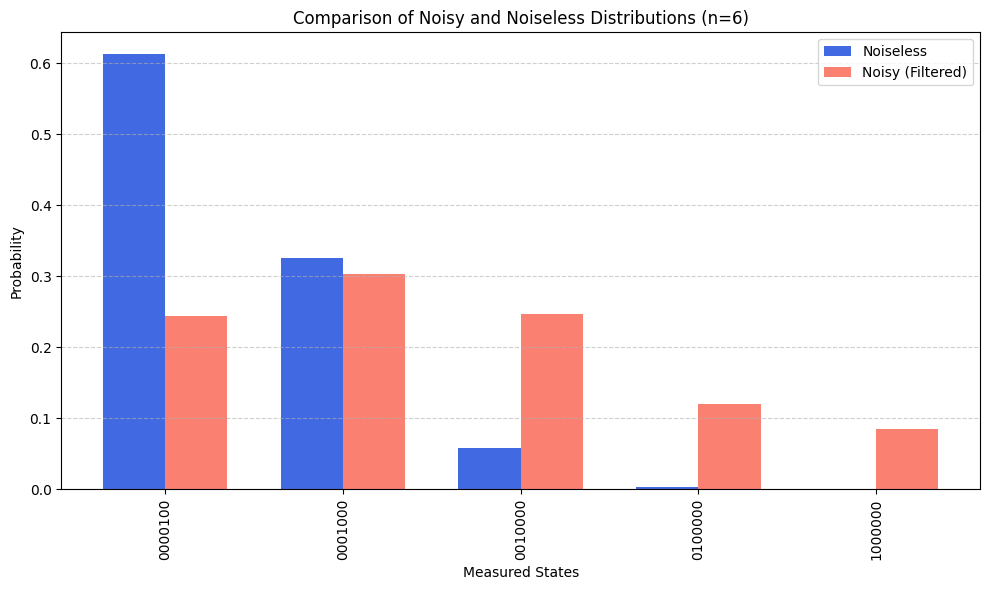

Total Variation Distance (TVD): 0.3920
Kullback-Leibler Divergence (KL): 0.5663


In [18]:
filter_counts_inplace(noisy_counts, remove_count=2)

# Compare distributions
compare_distributions(noisy_counts, noiseless_counts, n=n, 
                      filter_hamming=True, 
                      title_prefix="Comparison of Noisy and Noiseless Distributions",
                      figsize=(10, 6),
                      show_metrics=True,
                      return_metrics=False)

___
___